In [126]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
driver_df = pd.read_csv('data/telematics.csv')
driver_df = driver_df.drop(columns = ['Territory'])
categorical_features = ['Insured.sex','Marital','Car.use','Region']

# Create the encoder object
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(driver_df[categorical_features])

# Get feature names after encoding
feature_names = encoder.get_feature_names_out(categorical_features)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=driver_df.index)

# Drop original categorical columns and concatenate encoded columns
numerical_features = [col for col in driver_df.columns if col not in categorical_features]
driver_df = pd.concat([driver_df[numerical_features], encoded_df], axis=1)

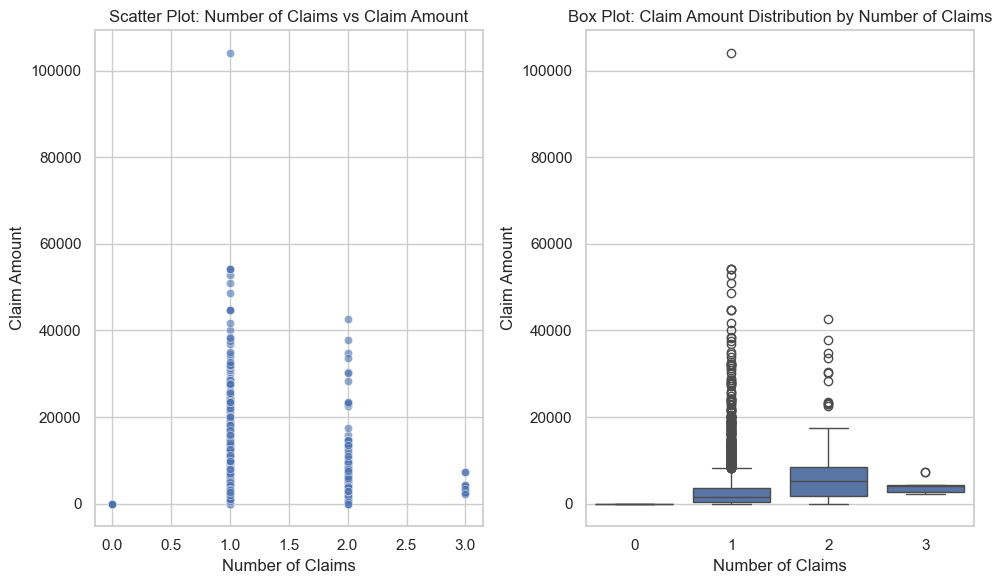

Average claim amount by number of claims:
   NB_Claim         mean  count
0         0     0.000000  95728
1         1  3046.376576   4061
2         2  6720.188023    200
3         3  4077.493669     11


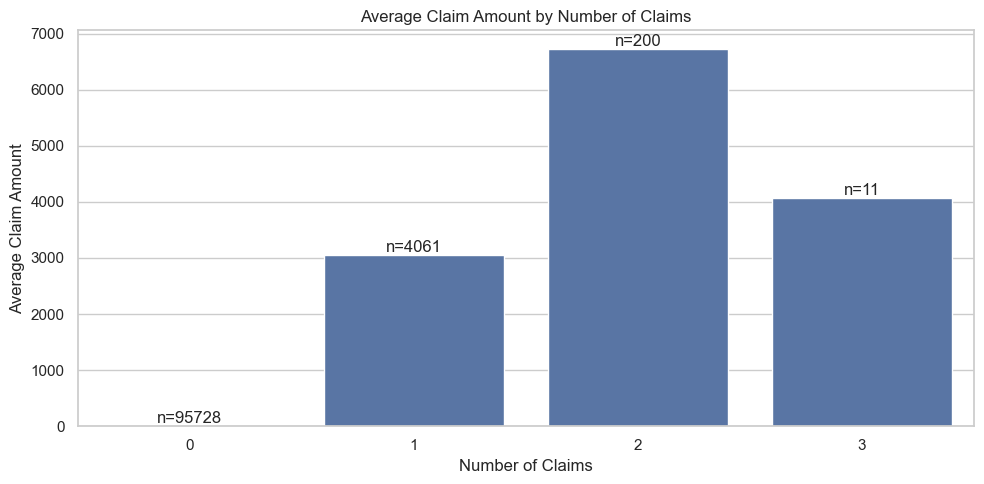

In [132]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Option 1: Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(x="NB_Claim", y="AMT_Claim", data=driver_df, alpha=0.6)
plt.title("Scatter Plot: Number of Claims vs Claim Amount")
plt.xlabel("Number of Claims")
plt.ylabel("Claim Amount")

# Option 2: Box plot showing distribution of claim amounts by number of claims
plt.subplot(1, 2, 2)
sns.boxplot(x="NB_Claim", y="AMT_Claim", data=driver_df)
plt.title("Box Plot: Claim Amount Distribution by Number of Claims")
plt.xlabel("Number of Claims")
plt.ylabel("Claim Amount")

# Adjust layout
plt.tight_layout()
plt.show()

# Additional analysis - Calculating average claim amount per number of claims
avg_claim_by_count = driver_df.groupby("NB_Claim")["AMT_Claim"].agg(['mean', 'count']).reset_index()
print("Average claim amount by number of claims:")
print(avg_claim_by_count)

# Create a bar chart for the average claim amount by number of claims
plt.figure(figsize=(10, 5))
sns.barplot(x="NB_Claim", y="mean", data=avg_claim_by_count)
plt.title("Average Claim Amount by Number of Claims")
plt.xlabel("Number of Claims")
plt.ylabel("Average Claim Amount")
plt.xticks(rotation=0)

# Add count labels on top of each bar
for i, row in enumerate(avg_claim_by_count.itertuples()):
    plt.text(i, row.mean, f"n={row.count}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [3]:
driver_df_1 = driver_df.copy()

# Method 2: Using map with lambda
driver_df_1['NB_Claim'] = driver_df_1['NB_Claim'].map(lambda x: 1 if x > 0 else 0)

driver_df_1_train = driver_df_1
driver_df_1_train = driver_df_1_train.drop(columns=['AMT_Claim'])

In [71]:
X = driver_df_1_train.drop('NB_Claim', axis=1)
#X = driver_df_1_train
y = driver_df_1_train['NB_Claim']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train, random_state=42)

In [14]:
scale_pos_weight = 20
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=13,
    n_estimators=500,
    random_state=42,
    eval_metric='auc',  # Add eval_metric here in the constructor
    early_stopping_rounds=10,
    scale_pos_weight=scale_pos_weight
)

xgb_classifier.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
    verbose=True)

80000

In [95]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'early_stopping_rounds': 10,
    }
    
    # Create classifier with current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Train with early stopping
    model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
        verbose=False
    )
    
    # Get predictions on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_val, y_pred)
    
    return auc_score

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print best results
print('Best trial:')
print('  Value (AUC):', study.best_trial.value)
print('  Params:')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

# Train final model with best parameters
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
    verbose=True
)
# cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

[I 2025-02-23 16:12:34,206] A new study created in memory with name: no-name-698a37b6-b4bd-40ab-b568-33571dcfdb7d
[I 2025-02-23 16:12:36,980] Trial 0 finished with value: 0.9176135513720126 and parameters: {'scale_pos_weight': 11.493791331281535, 'learning_rate': 0.11987454737956563, 'max_depth': 13, 'n_estimators': 617, 'min_child_weight': 1, 'subsample': 0.8196970936559846, 'colsample_bytree': 0.6117197061746061, 'gamma': 1.936392821703628}. Best is trial 0 with value: 0.9176135513720126.
[I 2025-02-23 16:12:39,404] Trial 1 finished with value: 0.8949672453386153 and parameters: {'scale_pos_weight': 11.35383830089957, 'learning_rate': 0.27251728155770727, 'max_depth': 5, 'n_estimators': 644, 'min_child_weight': 1, 'subsample': 0.7611037284332385, 'colsample_bytree': 0.7812339397793768, 'gamma': 4.220346870855941}. Best is trial 0 with value: 0.9176135513720126.
[I 2025-02-23 16:12:43,931] Trial 2 finished with value: 0.8616450619951966 and parameters: {'scale_pos_weight': 19.29444628

Best trial:
  Value (AUC): 0.9248149915999234
  Params:
    scale_pos_weight: 28.928852290768358
    learning_rate: 0.04254770256380957
    max_depth: 12
    n_estimators: 854
    min_child_weight: 5
    subsample: 0.6269703469861848
    colsample_bytree: 0.8404548839754977
    gamma: 3.8950349298108593


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [97]:
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-auc:0.88368	validation_1-auc:0.80062
[1]	validation_0-auc:0.92063	validation_1-auc:0.82051
[2]	validation_0-auc:0.93507	validation_1-auc:0.82818
[3]	validation_0-auc:0.94394	validation_1-auc:0.83836
[4]	validation_0-auc:0.95045	validation_1-auc:0.84448
[5]	validation_0-auc:0.95441	validation_1-auc:0.84818
[6]	validation_0-auc:0.95720	validation_1-auc:0.85326
[7]	validation_0-auc:0.95923	validation_1-auc:0.85726
[8]	validation_0-auc:0.96186	validation_1-auc:0.85886
[9]	validation_0-auc:0.96351	validation_1-auc:0.86123
[10]	validation_0-auc:0.96582	validation_1-auc:0.86448
[11]	validation_0-auc:0.96783	validation_1-auc:0.86595
[12]	validation_0-auc:0.96897	validation_1-auc:0.86710
[13]	validation_0-auc:0.97074	validation_1-auc:0.86926
[14]	validation_0-auc:0.97214	validation_1-auc:0.87007
[15]	validation_0-auc:0.97328	validation_1-auc:0.87084
[16]	validation_0-auc:0.97394	validation_1-auc:0.87208
[17]	validation_0-auc:0.97494	validation_1-auc:0.87265
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8404548839754977, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=3.8950349298108593,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04254770256380957,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=854, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

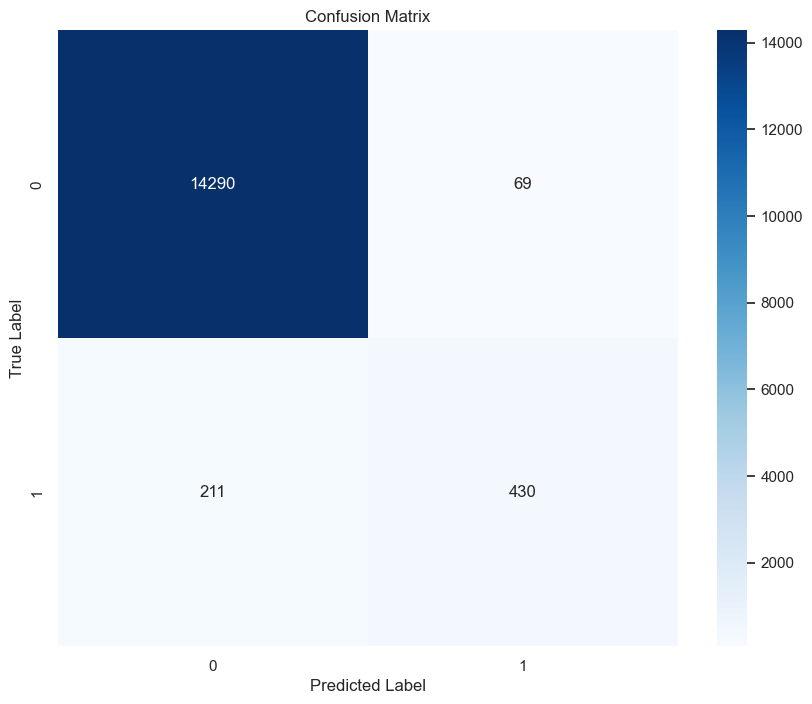

In [151]:
# def predict_with_threshold(model, X, threshold=0.4):
#     # Get probability predictions
#     y_pred_proba = model.predict_proba(X)[:, 1]
#     # Apply threshold
#     return (y_pred_proba >= threshold).astype(int)

# y_pred = predict_with_threshold(xgb_classifier, X_test, threshold = 0.5)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [125]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)  # Round to 3 decimal places

# Plot classification report as a heatmap
# plt.figure(figsize=(12, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='RdYlGn', center=0.85)
# plt.title('Classification Report Heatmap')
# plt.show()

# Print the numerical classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14359
           1       0.87      0.52      0.65       641

    accuracy                           0.98     15000
   macro avg       0.93      0.76      0.82     15000
weighted avg       0.97      0.98      0.97     15000



/var/folders/8m/x5x5_dcs5tx95d8b0v2mhb1r0000gn/T/ipykernel_47541/2548460110.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette=colors)


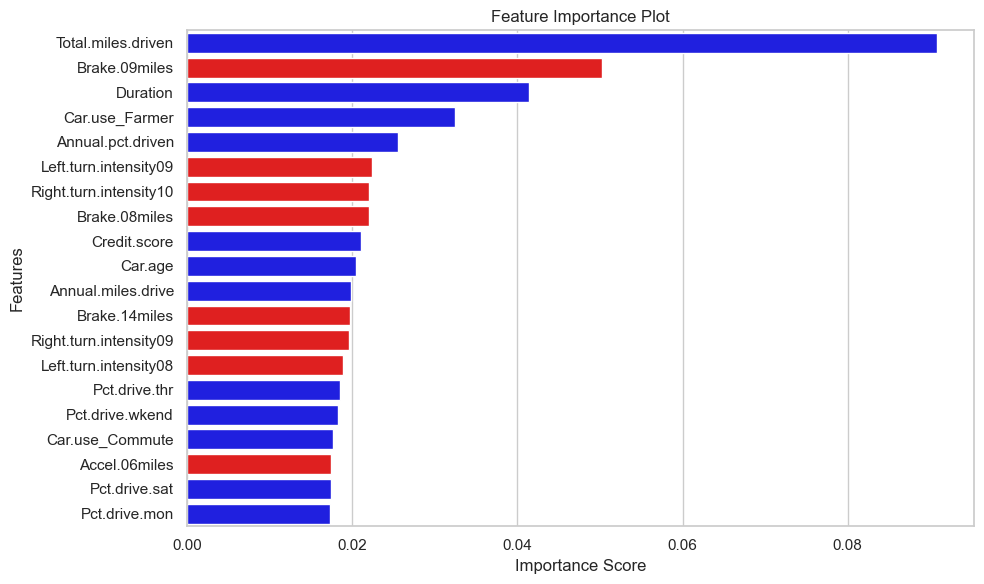


Feature Importance:
                   feature  importance
7       Total.miles.driven    0.090755
31           Brake.09miles    0.050202
0                 Duration    0.041402
48          Car.use_Farmer    0.032421
6        Annual.pct.driven    0.025485
36   Left.turn.intensity09    0.022396
42  Right.turn.intensity10    0.022043
30           Brake.08miles    0.021985
3             Credit.score    0.021048
2                  Car.age    0.020460
4       Annual.miles.drive    0.019899
34           Brake.14miles    0.019693
41  Right.turn.intensity09    0.019637
35   Left.turn.intensity08    0.018827
11           Pct.drive.thr    0.018487
19         Pct.drive.wkend    0.018267
47         Car.use_Commute    0.017693
23           Accel.06miles    0.017414
13           Pct.drive.sat    0.017401
8            Pct.drive.mon    0.017292


In [141]:
feature_importance = pd.DataFrame({
    'feature': X_test.columns,  # Use training data columns
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance = feature_importance[0:20]
tele_feature = ["Brake.09miles", "Left.turn.intensity09", "Right.turn.intensity10", "Brake.08miles", "Brake.14miles", "Right.turn.intensity09", "Left.turn.intensity08", "Accel.06miles"] 
colors = ['red' if feature in tele_feature else 'blue' for feature in feature_importance['feature']]
# Create feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette=colors)
plt.title('Feature Importance Plot')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

In [117]:
feature_importance

,feature,importance
7,Total.miles.driven,0.090755
31,Brake.09miles,0.050202
0,Duration,0.041402
48,Car.use_Farmer,0.032421
6,Annual.pct.driven,0.025485
36,Left.turn.intensity09,0.022396
42,Right.turn.intensity10,0.022043
30,Brake.08miles,0.021985
3,Credit.score,0.021048
2,Car.age,0.020460


In [112]:
import pickle

# Save the model
with open('models/xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

In [134]:
driver_df_2 = driver_df.copy()
driver_df_2 = driver_df_2[driver_df_2['NB_Claim'] >= 1]
driver_df_2['NB_Claim'] = driver_df_2['NB_Claim'].map(lambda x: 1 if x > 1 else 0)

driver_df_2_train = driver_df_2
driver_df_2_train = driver_df_2_train.drop(columns=['AMT_Claim'])
X = driver_df_2_train.drop('NB_Claim', axis=1)
#X = driver_df_1_train
y = driver_df_2_train['NB_Claim']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify = y_train, random_state=42)

In [135]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'early_stopping_rounds': 10,
    }
    
    # Create classifier with current hyperparameters
    model = xgb.XGBClassifier(**param)
    
    # Train with early stopping
    model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
        verbose=False
    )
    
    # Get predictions on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_val, y_pred)
    
    return auc_score

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print best results
print('Best trial:')
print('  Value (AUC):', study.best_trial.value)
print('  Params:')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2025-02-24 23:21:59,602] A new study created in memory with name: no-name-46d4dac6-e890-4f03-9a58-60e1f58269b9
[I 2025-02-24 23:21:59,767] Trial 0 finished with value: 0.9394394394394394 and parameters: {'scale_pos_weight': 18.535971249975315, 'learning_rate': 0.29492310992894877, 'max_depth': 3, 'n_estimators': 870, 'min_child_weight': 6, 'subsample': 0.7270906515400989, 'colsample_bytree': 0.9072873517408835, 'gamma': 1.2037509938606994}. Best is trial 0 with value: 0.9394394394394394.
[I 2025-02-24 23:21:59,900] Trial 1 finished with value: 0.9282854282854283 and parameters: {'scale_pos_weight': 12.092680937062566, 'learning_rate': 0.11221383057202954, 'max_depth': 9, 'n_estimators': 626, 'min_child_weight': 7, 'subsample': 0.9979969517576295, 'colsample_bytree': 0.6601948606907632, 'gamma': 2.851447929506871}. Best is trial 0 with value: 0.9394394394394394.
[I 2025-02-24 23:22:00,016] Trial 2 finished with value: 0.9691119691119692 and parameters: {'scale_pos_weight': 17.8605373

Best trial:
  Value (AUC): 0.970970970970971
  Params:
    scale_pos_weight: 17.82664893705778
    learning_rate: 0.17516152214817005
    max_depth: 7
    n_estimators: 267
    min_child_weight: 1
    subsample: 0.6404499521340277
    colsample_bytree: 0.946504783590435
    gamma: 3.2689135519992707


In [137]:
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-auc:0.85984	validation_1-auc:0.78364
[1]	validation_0-auc:0.91404	validation_1-auc:0.82579
[2]	validation_0-auc:0.95136	validation_1-auc:0.83019
[3]	validation_0-auc:0.96924	validation_1-auc:0.85496
[4]	validation_0-auc:0.97621	validation_1-auc:0.85932
[5]	validation_0-auc:0.98298	validation_1-auc:0.86254
[6]	validation_0-auc:0.98542	validation_1-auc:0.86218
[7]	validation_0-auc:0.98876	validation_1-auc:0.87652
[8]	validation_0-auc:0.99136	validation_1-auc:0.88846
[9]	validation_0-auc:0.99287	validation_1-auc:0.88910
[10]	validation_0-auc:0.99491	validation_1-auc:0.91034
[11]	validation_0-auc:0.99588	validation_1-auc:0.91227
[12]	validation_0-auc:0.99597	validation_1-auc:0.91527
[13]	validation_0-auc:0.99678	validation_1-auc:0.92485
[14]	validation_0-auc:0.99757	validation_1-auc:0.93258
[15]	validation_0-auc:0.99823	validation_1-auc:0.93594
[16]	validation_0-auc:0.99872	validation_1-auc:0.93815
[17]	validation_0-auc:0.99913	validation_1-auc:0.93601
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.946504783590435, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=3.2689135519992707,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17516152214817005,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=267, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

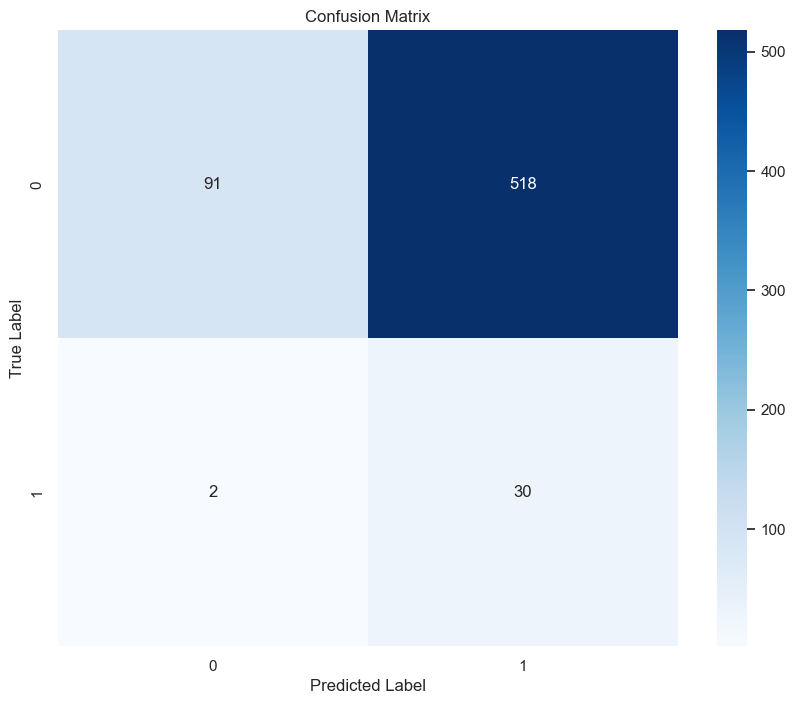


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.15      0.26       609
           1       0.05      0.94      0.10        32

    accuracy                           0.19       641
   macro avg       0.52      0.54      0.18       641
weighted avg       0.93      0.19      0.25       641



In [139]:
def predict_with_threshold(model, X, threshold=0.4):
    # Get probability predictions
    y_pred_proba = model.predict_proba(X)[:, 1]
    # Apply threshold
    return (y_pred_proba >= threshold).astype(int)

y_pred = predict_with_threshold(xgb_classifier, X_test, threshold = 0.5)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)  # Round to 3 decimal places

# Plot classification report as a heatmap
# plt.figure(figsize=(12, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='RdYlGn', center=0.85)
# plt.title('Classification Report Heatmap')
# plt.show()

# Print the numerical classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [127]:
driver_df_amt = driver_df.copy()

# Method 2: Using map with lambda
# driver_df_amt['NB_Claim'] = driver_df_1['NB_Claim'].map(lambda x: 1 if x > 0 else 0)

# driver_df_1_train = driver_df_1
driver_df_amt = driver_df.drop(columns=['NB_Claim'])
X = driver_df_amt.drop('AMT_Claim', axis=1)
#X = driver_df_1_train
y = driver_df_amt['AMT_Claim']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [129]:
def objective(trial):
    # Define the hyperparameter search space for regression
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': 10,
    }
    
    # Create regressor with current hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Train with early stopping
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Get predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE (lower is better, but Optuna maximizes by default)
    # So we return the negative RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    # Alternatively, you can return R² (higher is better)
    # r2 = r2_score(y_val, y_pred)
    # return r2
    
    return -rmse  # Negative RMSE because Optuna maximizes by default

# Create and run Optuna study
study = optuna.create_study(direction='maximize')  # Maximizing negative RMSE (minimizing RMSE)
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print best results
print('Best trial:')
print('  Value (Negative RMSE):', study.best_trial.value)
print('  RMSE:', -study.best_trial.value)  # Convert back to actual RMSE
print('  Params:')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')


[I 2025-02-24 22:51:57,929] A new study created in memory with name: no-name-28e16855-fef3-48b8-b684-858506d5ee69
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-24 22:52:02,555] Trial 0 finished with value: -538.5306795653572 and parameters: {'learning_rate': 0.09868441306151178, 'max_depth': 5, 'n_estimators': 710, 'min_child_weight': 3, 'subsample': 0.8622466777202019, 'colsample_bytree': 0.9316699185349224, 'gamma': 2.067615286101998, 'reg_alpha': 0.8302194035744187, 'reg_lambda': 0.28160437831989305}. Best is trial 0 with value: -538.5306795653572.
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

Best trial:
  Value (Negative RMSE): -1.2188095058144286
  RMSE: 1.2188095058144286
  Params:
    learning_rate: 0.2709967135532447
    max_depth: 10
    n_estimators: 984
    min_child_weight: 3
    subsample: 0.8722179312820009
    colsample_bytree: 0.785855529569354
    gamma: 3.039420849517904
    reg_alpha: 0.08462160990766547
    reg_lambda: 0.015962670556993505
[0]	validation_0-rmse:1165.65956	validation_1-rmse:1028.84288
[1]	validation_0-rmse:1070.59888	validation_1-rmse:950.63862
[2]	validation_0-rmse:975.53049	validation_1-rmse:869.08007
[3]	validation_0-rmse:913.22579	validation_1-rmse:813.58647
[4]	validation_0-rmse:860.85707	validation_1-rmse:771.14396
[5]	validation_0-rmse:823.71397	validation_1-rmse:725.26630
[6]	validation_0-rmse:792.38643	validation_1-rmse:701.36207
[7]	validation_0-rmse:775.63474	validation_1-rmse:690.67916
[8]	validation_0-rmse:760.49483	validation_1-rmse:688.62628
[9]	validation_0-rmse:749.37022	validation_1-rmse:682.34575
[10]	validation_0-rmse:728

/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Train final model with best parameters
best_params = study.best_trial.params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# Evaluate final model
train_pred = final_model.predict(X_train)
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

print("\nFinal Model Evaluation:")
print("Train RMSE:", mean_squared_error(y_train, train_pred, squared=False))
print("Validation RMSE:", mean_squared_error(y_val, val_pred, squared=False))
print("Test RMSE:", mean_squared_error(y_test, test_pred, squared=False))
print("Test R²:", r2_score(y_test, test_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))